# training.ipynb

This is code (in progress) for building and training the neural network.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
# import keras_one_cycle_clr as ktool
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline 

import sys
sys.path.append("/home/jchishol/TRecNet")
import normalize
import shape_timesteps
import analysis

## Loading Files

In [2]:
# Jet type we want to use
name = 'e+mjets_train'

# Dataset to train and test on
dataset = h5py.File('/data/jchishol/ML_Data/variables_ttbar_parton_'+name+'.h5','r')

# Numpy array of [max,mean] for each variable
X_maxmean = np.load('X_maxmean_parton_'+name+'.npy')
Y_maxmean = np.load('Y_maxmean_parton_'+name+'.npy')

## Useful Variables

In [3]:
# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
Y_length = len(Y_keys)
X_length = len(X_keys)

# Variables keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

# Number of events in the dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size    # Used in helper codes

print(crop0)

9348801


## Scale the Data

In [4]:
# Scales data set to be between -1 and 1, with a mean of 0
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

## Split Data Into Training, Validation, and Testing

In [5]:
# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
#split1 = int(np.floor(0.70*crop0))
#split2 = int(np.floor(0.85*crop0))
split = int(np.floor(0.82*crop0))  # Taking ~82% for training and ~18% for validation amounts to ~70% of total being training and ~15% of total being validation

# Split into training, validation, and testing data for Y
#trainY, valY, testY = Y_total[0:split1,:], Y_total[split1:split2,:], Y_total[split2:,:]
#print("Training:",trainY.size/Y_total.size)
#print("Validation:",valY.size/Y_total.size)
#print("Testing:",testY.size/Y_total.size)

trainY, valY = Y_total[0:split,:], Y_total[split:,:]

# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# Split into training, validation, and testing data for jets and other
#trainX_jets, valX_jets, testX_jets = totalX_jets[0:split1,:,:], totalX_jets[split1:split2,:,:], totalX_jets[split2:,:,:]
#trainX_other, valX_other, testX_other = totalX_other[0:split1,:], totalX_other[split1:split2,:], totalX_other[split2:,:]

trainX_jets, valX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, valX_other = totalX_other[0:split,:], totalX_other[split:,:]

## Histograms of Scaled Input X and Y Variables

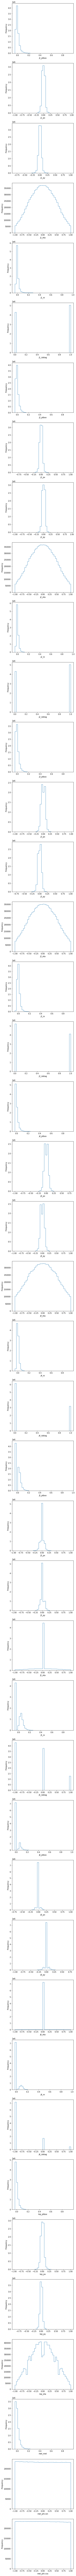

In [6]:
# Define whether or not to plot
show = True

# Plot histograms
if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

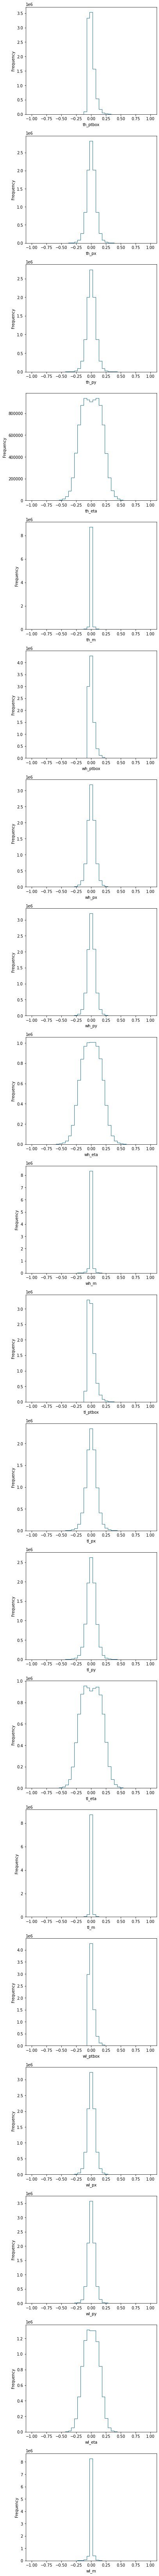

In [7]:
# Define whether or not to plot
show = True

# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Plot histograms
if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

## Build the Model

2022-05-28 10:45:52.130813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-05-28 10:45:52.130862: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-28 10:45:52.131352: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 6)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 flatten (Flatten)              (None, 36)           0           ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 43)           0           ['input_2[0][0]',                
                                                                  'flatten[0][0]']            

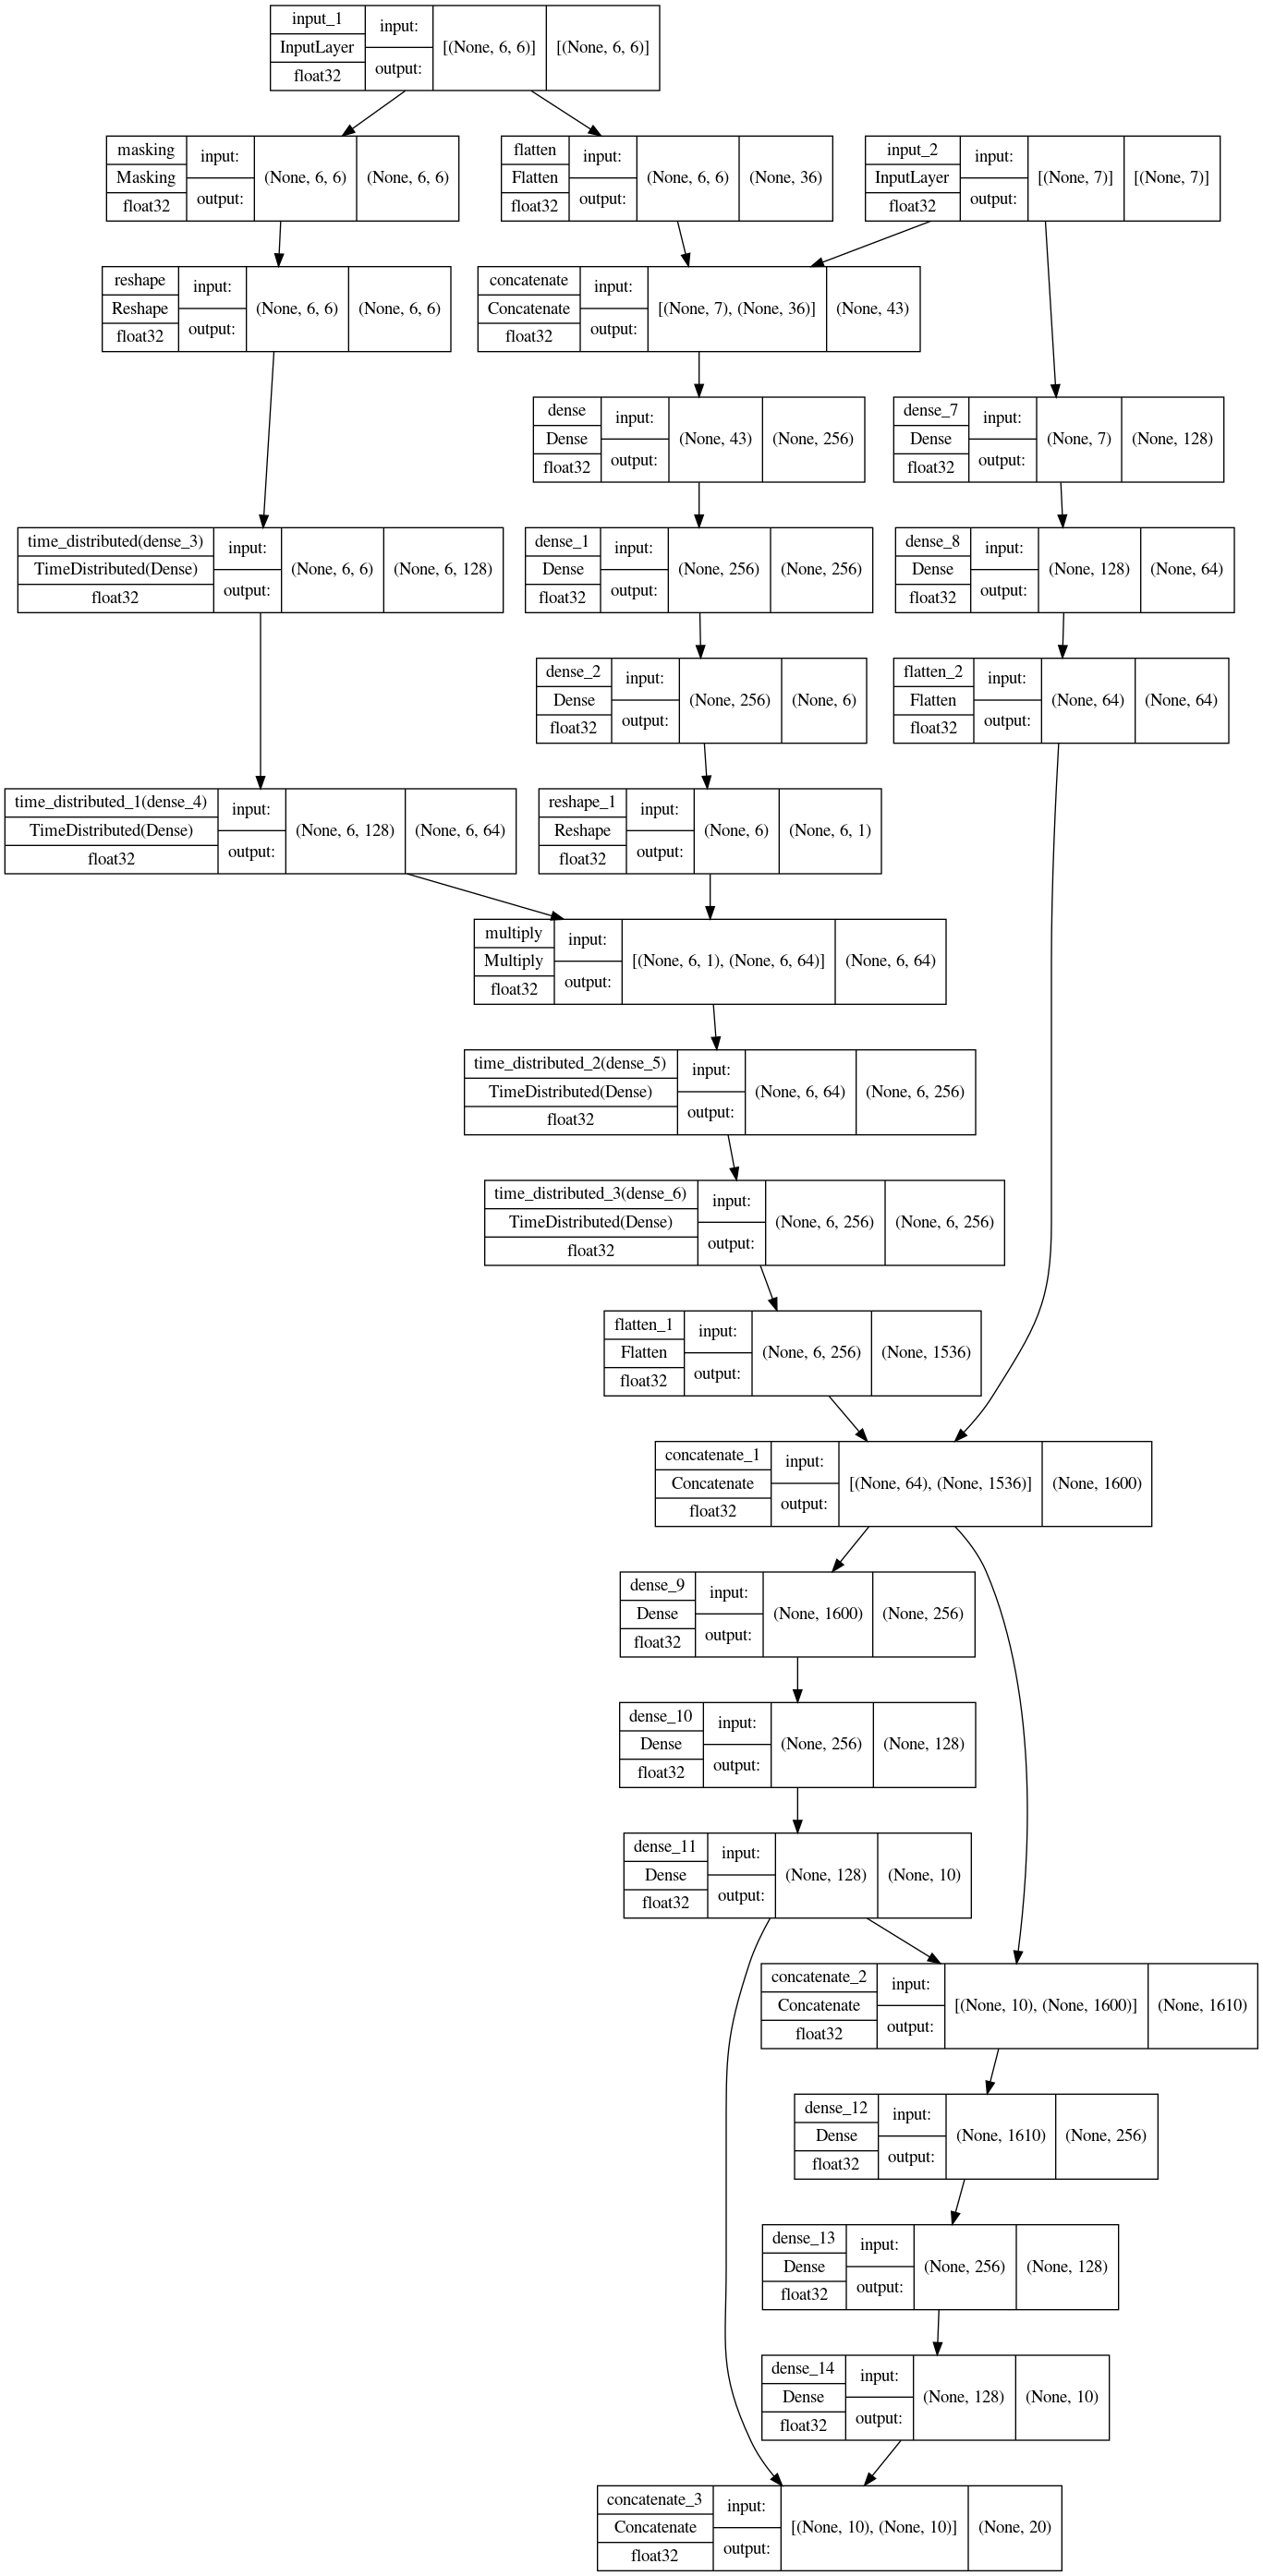

In [6]:
def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(256, activation='relu')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
    Shape_Dot = Reshape((-1,1))(PreDense3)
    
    TDDense11 = TimeDistributed(Dense(128, activation='relu'))(Maskshape)
    TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
    Dot_jets = Multiply()([Shape_Dot, TDDense12])
    TDDense13 = TimeDistributed(Dense(256, activation='relu'))(Dot_jets)
    TDDense14= TimeDistributed(Dense(256, activation='relu'))(TDDense13)
    flat_right = Flatten()(TDDense14)
    
    Dense21 = Dense(128, activation='relu')(other_input)
    Dense22 = Dense(64, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    
    ldense1 = Dense(256, activation='relu')(concat)
    ldense2 = Dense(128, activation='relu')(ldense1)
    loutput = Dense(len(Y_names)//2)(ldense2)
    
    hconcat = concatenate([loutput, concat])
    hdense1 = Dense(256, activation='relu')(hconcat)
    hdense2 = Dense(128, activation='relu')(hdense1)
    houtput = Dense(len(Y_names)//2)(hdense2)
    
    output = concatenate([houtput, loutput])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    
    # Define loss function
    def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mae', optimizer= optimizer, metrics=['mse'])
    
    return model 

# Define loss function (again?)
def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
# Load or build model
#model = keras.models.load_model('new_model.keras', custom_objects={'loss_fc':loss_fc})
model = build_model()
model.summary()
keras.utils.plot_model(model,to_file='Model_Custom.png',show_shapes=True,show_dtype=True,show_layer_names=True)

## Fit the Model 

In [9]:
# Set when to stop (has to do with loss?)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)  # patience=4 means stop training after 4 epochs with no improvement
clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999)
# class_weight = {0:2, 1:1, 2:1, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:2, 16:1, 17:1, 18:1, 19:1}

# Set number of epochs (runs through?)
Epochs= 256

# del X_total
# del Y_total
# def loss(true, pred):
#     return K.mean(K.square(true-pred)*(1+K.square(true)))


# Fit the model (i.e. TRAIN the model)
history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([valX_jets, valX_other], valY), shuffle=True, callbacks=[early_stop],
                    batch_size=1000)
#history = model.fit([totalX_jets, totalX_other], Y_total, verbose=1, epochs=Epochs,
#                   validation_split=0.1, shuffle=True, callbacks=[early_stop],
#                    batch_size=1000)

Epoch 1/256
7667/7667 [==============================] - 122s 16ms/step - loss: 0.0234 - mse: 0.0017 - val_loss: 0.0229 - val_mse: 0.0017
Epoch 2/256
7667/7667 [==============================] - 120s 16ms/step - loss: 0.0214 - mse: 0.0016 - val_loss: 0.0213 - val_mse: 0.0016
Epoch 3/256
7667/7667 [==============================] - 121s 16ms/step - loss: 0.0211 - mse: 0.0015 - val_loss: 0.0212 - val_mse: 0.0015
Epoch 4/256
7667/7667 [==============================] - 120s 16ms/step - loss: 0.0211 - mse: 0.0015 - val_loss: 0.0212 - val_mse: 0.0015
Epoch 5/256
7667/7667 [==============================] - 121s 16ms/step - loss: 0.0210 - mse: 0.0015 - val_loss: 0.0211 - val_mse: 0.0015
Epoch 6/256
7667/7667 [==============================] - 120s 16ms/step - loss: 0.0210 - mse: 0.0015 - val_loss: 0.0211 - val_mse: 0.0015
Epoch 7/256
7667/7667 [==============================] - 121s 16ms/step - loss: 0.0209 - mse: 0.0015 - val_loss: 0.0210 - val_mse: 0.0015
Epoch 8/256
7667/7667 [===========

7667/7667 [==============================] - 121s 16ms/step - loss: 0.0201 - mse: 0.0014 - val_loss: 0.0205 - val_mse: 0.0015
Epoch 61/256
7667/7667 [==============================] - 121s 16ms/step - loss: 0.0201 - mse: 0.0014 - val_loss: 0.0205 - val_mse: 0.0015
Epoch 62/256
7667/7667 [==============================] - 121s 16ms/step - loss: 0.0201 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 63/256
7667/7667 [==============================] - 121s 16ms/step - loss: 0.0201 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 64/256
7667/7667 [==============================] - 121s 16ms/step - loss: 0.0200 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 65/256
7667/7667 [==============================] - 121s 16ms/step - loss: 0.0200 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 66/256
7667/7667 [==============================] - 121s 16ms/step - loss: 0.0200 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 67/256
7667/7667 [================

## Save the Model

In [10]:
model.save('Model_Custom.keras')

In [ ]:
np.save('trainHistory_Model_Custom.npy',history.history)
#history=np.load('trainHistory_Model_Custom.npy',allow_pickle='TRUE').item()

## Plot Training Stats 

In [ ]:
#plt.xlabel('Training Iterations')
#plt.ylabel('Learning Rate')
#plt.title("CLR - 'triangular' Policy")
#plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

Text(0.5, 1.0, 'MSE loss')

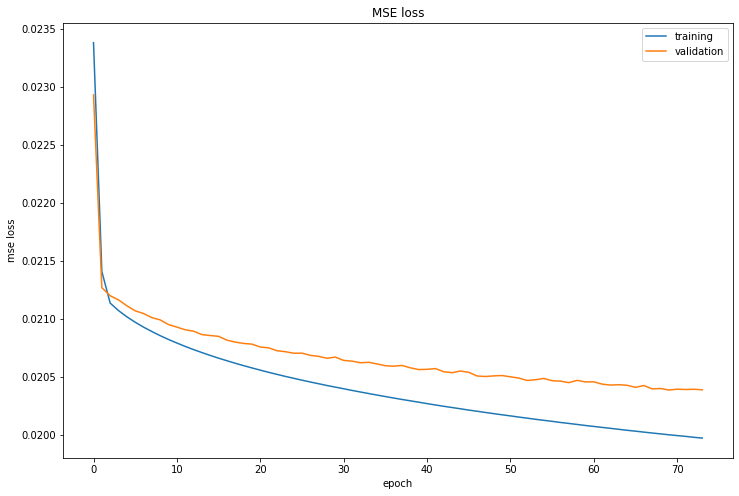

In [11]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

# Testing and Plots

This part of the code tests the machine learning and data.

## Make Predictions with Validation Data

In [13]:
# Predict using un-scaled variables
predictions_unscaled = model.predict([valX_jets, valX_other])
true_unscaled = valY 

# Unscale the scaled predictions
predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)

## Training Scale Plots (Tao's Code)

In [15]:
Analysis = analysis.Analysis
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0014903393864411593
 
th_ptbox MSE, MAE :  0.0006145951 0.0166371214
th_px MSE, MAE :  0.0011953438 0.0207903939
th_py MSE, MAE :  0.0012771419 0.0213761647
th_eta MSE, MAE :  0.0054707679 0.0408405272
th_m MSE, MAE :  0.0005941705 0.0087232272
wh_ptbox MSE, MAE :  0.0006679190 0.0163827372
wh_px MSE, MAE :  0.0012006100 0.0207573106
wh_py MSE, MAE :  0.0011936062 0.0206001692
wh_eta MSE, MAE :  0.0067109219 0.0461603112
wh_m MSE, MAE :  0.0007999318 0.0123292435
tl_ptbox MSE, MAE :  0.0005067320 0.0160317227
tl_px MSE, MAE :  0.0008090303 0.0191820644
tl_py MSE, MAE :  0.0006426488 0.0170842081
tl_eta MSE, MAE :  0.0035327244 0.0390410870
tl_m MSE, MAE :  0.0006030747 0.0087561927
wl_ptbox MSE, MAE :  0.0002832463 0.0123389998
wl_px MSE, MAE :  0.0002933754 0.0126674836
wl_py MSE, MAE :  0.0002370517 0.0113842590
wl_eta MSE, MAE :  0.0022403612 0.0333847055
wl_m MSE, MAE :  0.0009335345 0.0132773179


In [16]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 322.57163104957823
 
th_pt MSE, MAE :  1803.2584236331 28.4978840821
th_eta MSE, MAE :  0.4592963883 0.3742085520
th_phi MSE, MAE :  0.6839388335 0.4520120001
th_m MSE, MAE :  35.3603527422 2.1280407083
wh_pt MSE, MAE :  1341.8915395737 23.2211252634
wh_eta MSE, MAE :  0.5334414495 0.4115484936
wh_phi MSE, MAE :  0.6482838960 0.4532615342
wh_m MSE, MAE :  36.2656053676 2.6251699535
tl_pt MSE, MAE :  1238.5821523808 25.0641756702
tl_eta MSE, MAE :  0.2933681439 0.3557734177
tl_phi MSE, MAE :  0.4032143793 0.3352803643
tl_m MSE, MAE :  35.8898765043 2.1360711719
wl_pt MSE, MAE :  623.7661175297 18.3108579567
wl_eta MSE, MAE :  0.2859534800 0.3771692003
wl_phi MSE, MAE :  0.1852003102 0.2414087809
wl_m MSE, MAE :  37.2058698968 2.6506408895


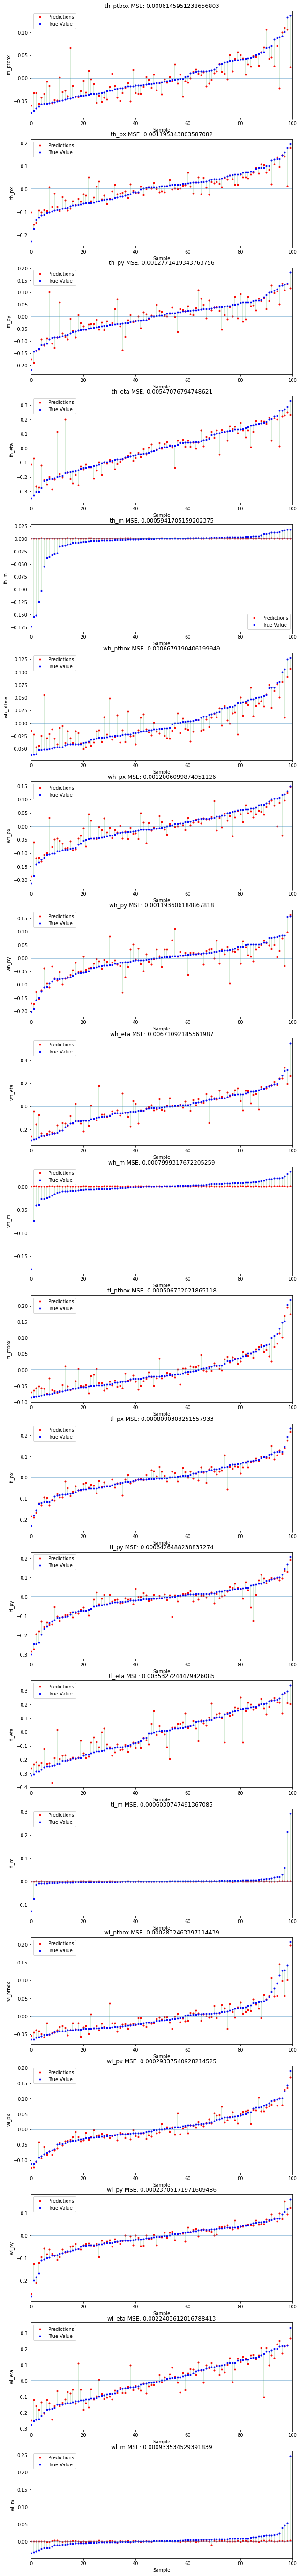

In [17]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

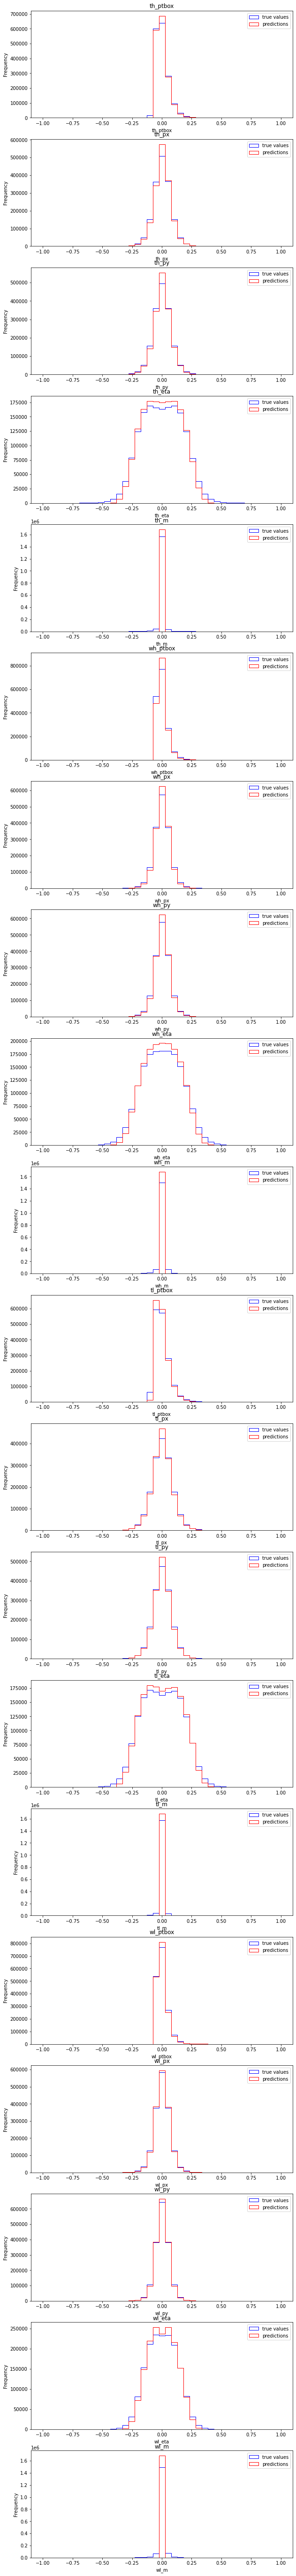

In [18]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

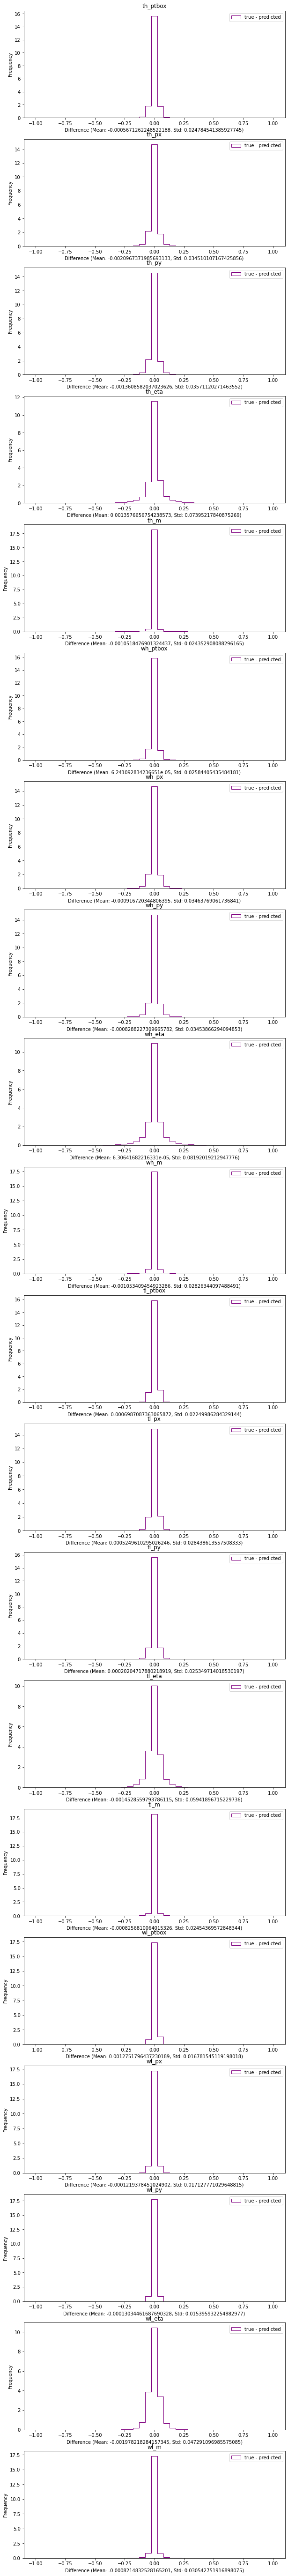

In [19]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

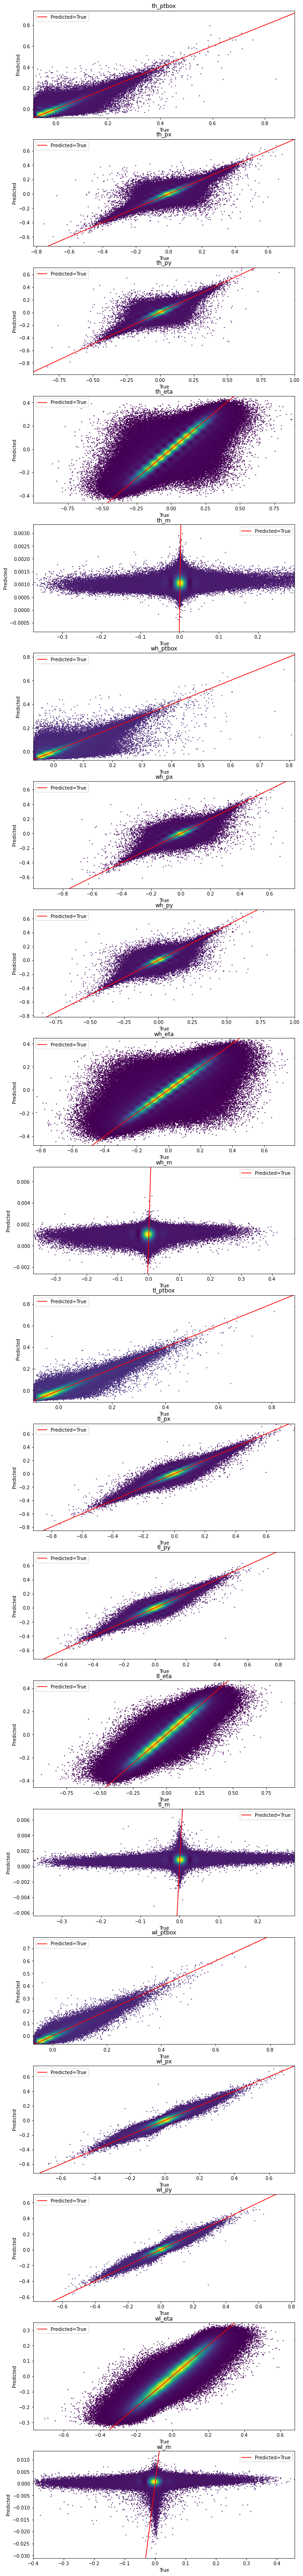

In [20]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

## Original Scale Plots

In [21]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 322.57163104957823
 
th_pt MSE, MAE :  1803.2584236331 28.4978840821
th_eta MSE, MAE :  0.4592963883 0.3742085520
th_phi MSE, MAE :  0.6839388335 0.4520120001
th_m MSE, MAE :  35.3603527422 2.1280407083
wh_pt MSE, MAE :  1341.8915395737 23.2211252634
wh_eta MSE, MAE :  0.5334414495 0.4115484936
wh_phi MSE, MAE :  0.6482838960 0.4532615342
wh_m MSE, MAE :  36.2656053676 2.6251699535
tl_pt MSE, MAE :  1238.5821523808 25.0641756702
tl_eta MSE, MAE :  0.2933681439 0.3557734177
tl_phi MSE, MAE :  0.4032143793 0.3352803643
tl_m MSE, MAE :  35.8898765043 2.1360711719
wl_pt MSE, MAE :  623.7661175297 18.3108579567
wl_eta MSE, MAE :  0.2859534800 0.3771692003
wl_phi MSE, MAE :  0.1852003102 0.2414087809
wl_m MSE, MAE :  37.2058698968 2.6506408895


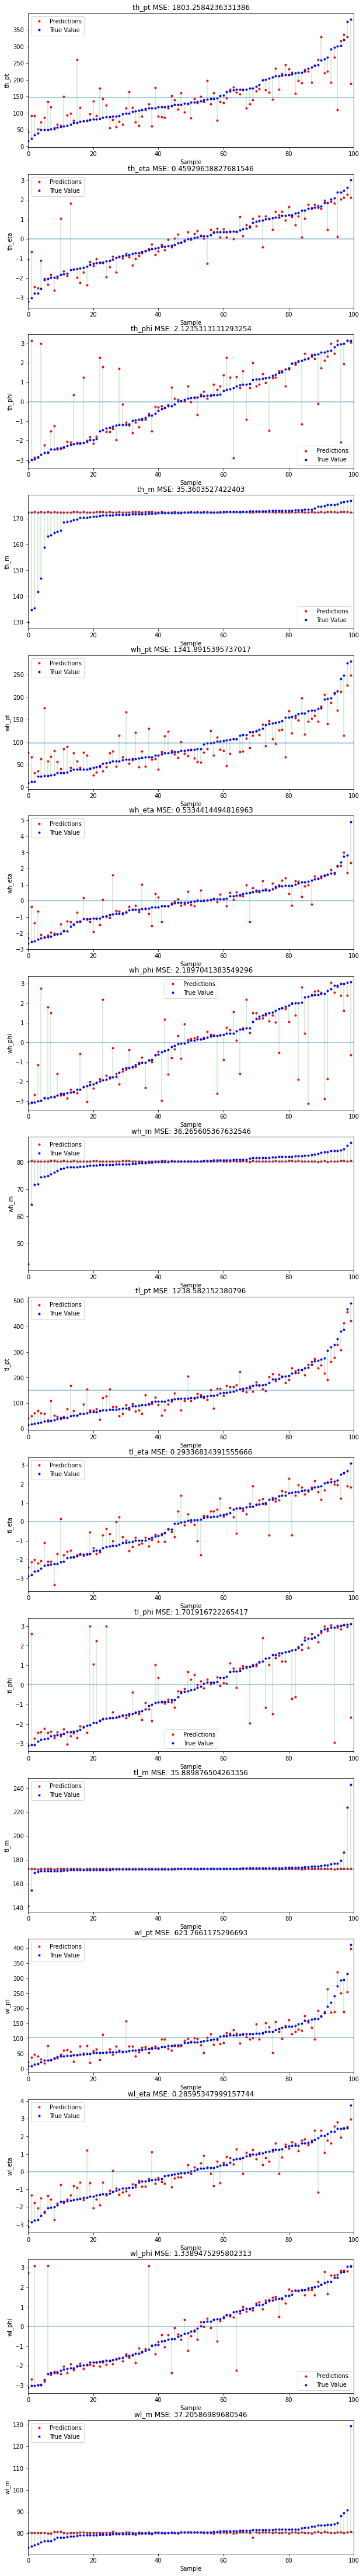

In [22]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

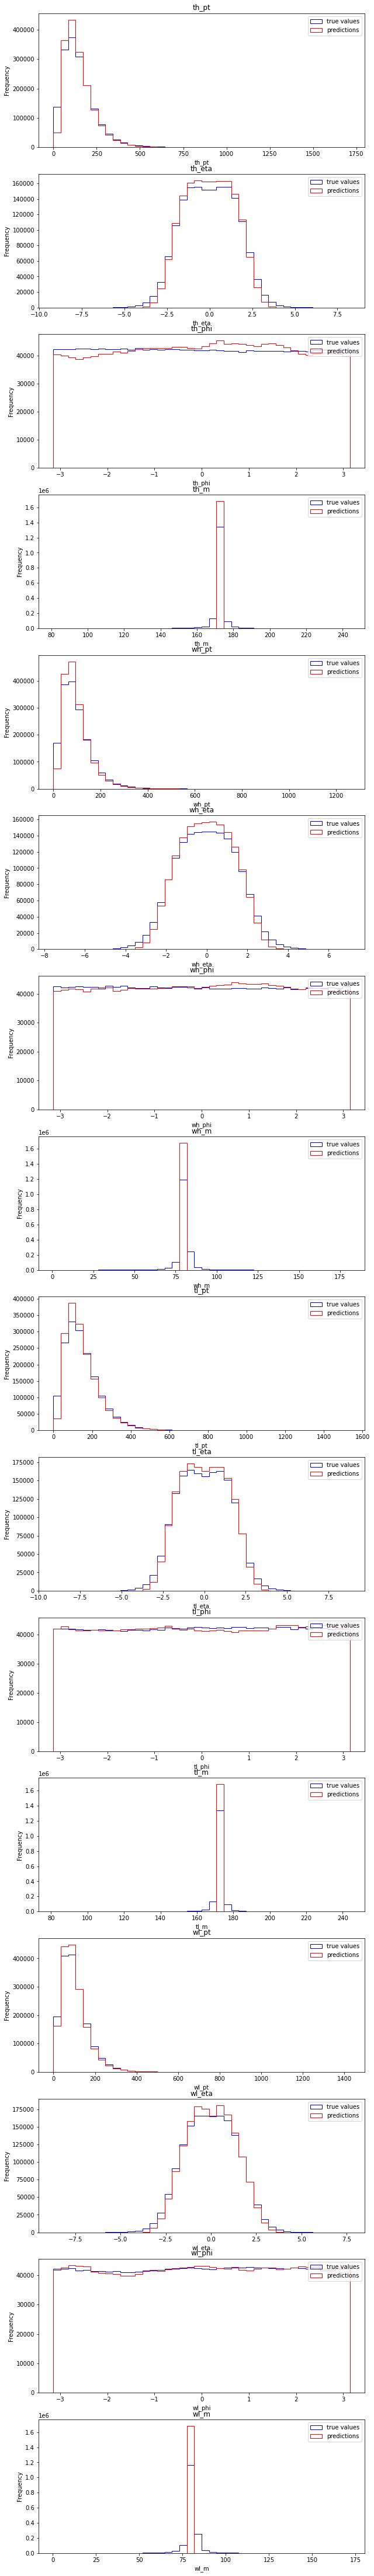

In [23]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

/home/jchishol/myVenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


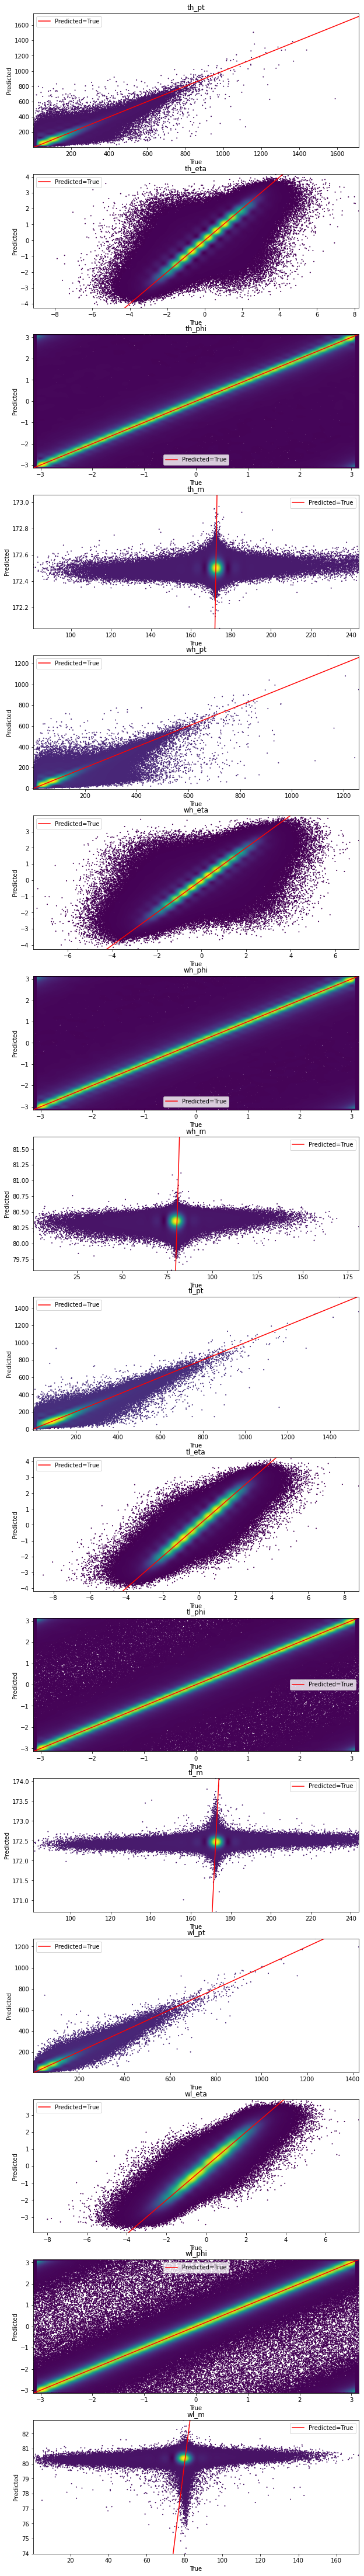

In [24]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

## Observables

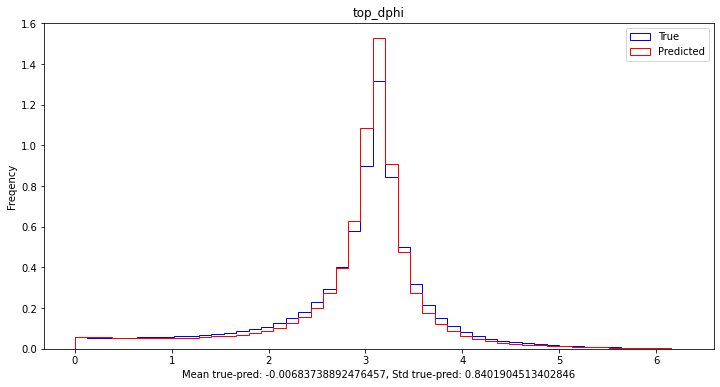

In [25]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

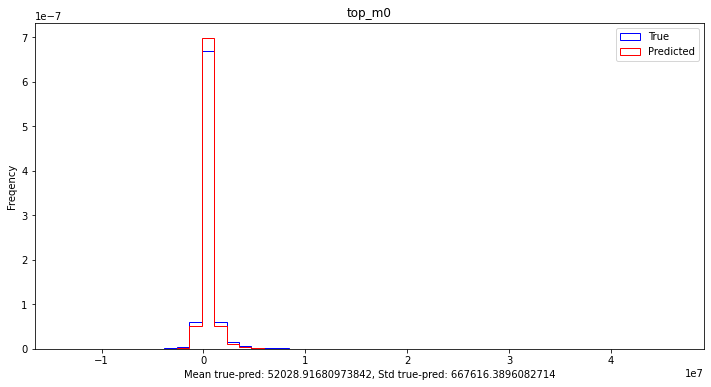

In [26]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

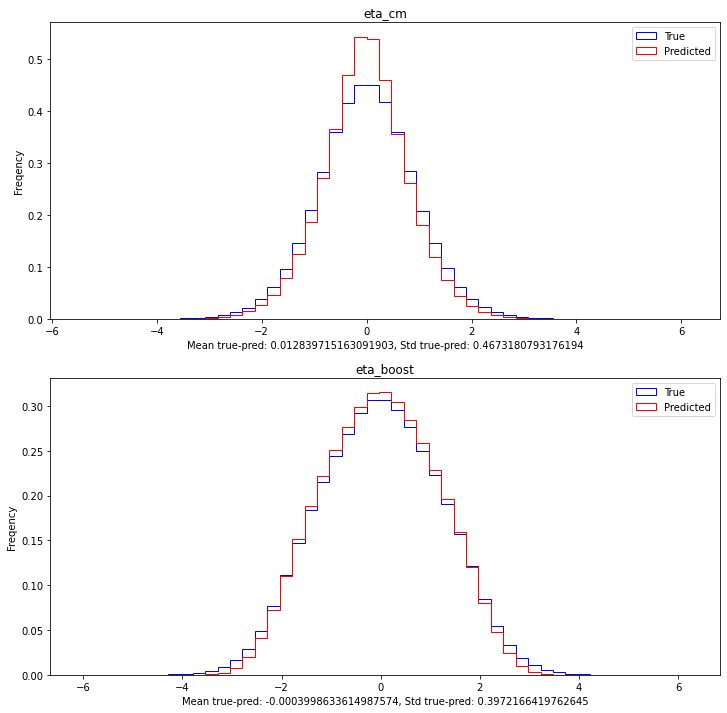

In [27]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])

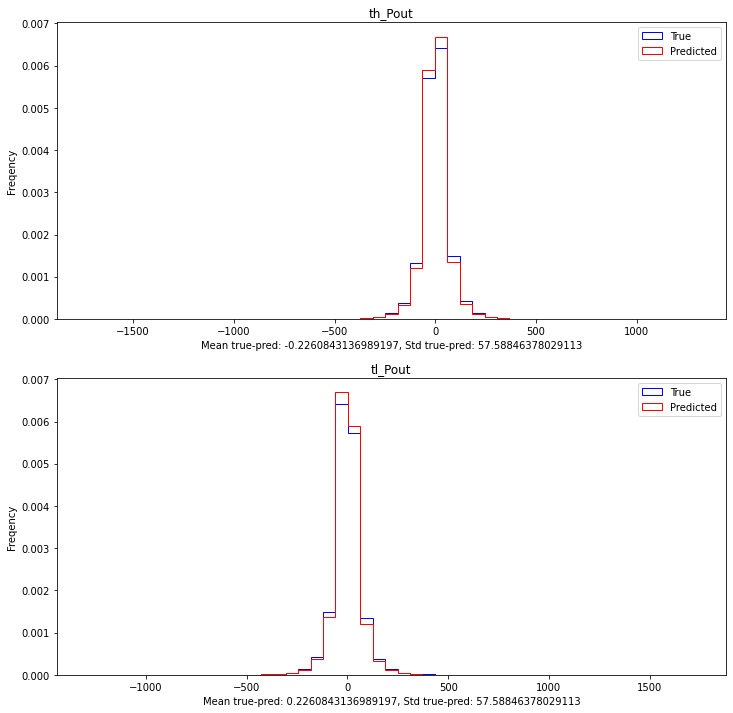

In [28]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])

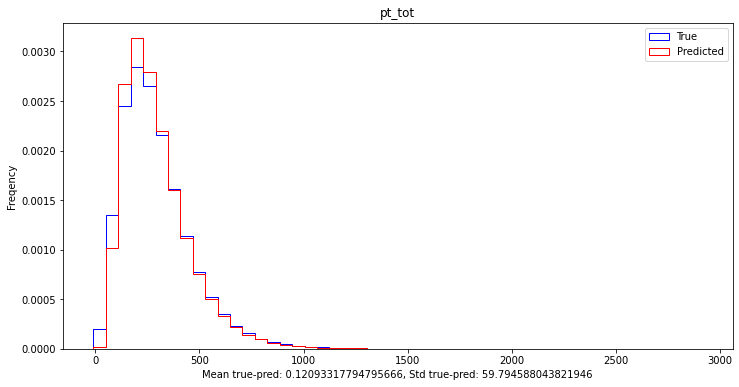

In [29]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])